In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 2

##-------------

train_mu = [ 0.0, 1.0 ]



train_rho = [ [-0.6] ]






train_sig = [ 1.0, 1.5 ]


##-------------


true_mu = [ 0.2, 0.8 ]






true_rho  = [ [-0.6] ]



true_sig = [ 0.9, 1.3 ]



#--- nominal
resolution = [ 0.5, 0.8  ]

#--- poor
#resolution = [ 1.0, 1.6  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'fit-pdf-toy-study-2d-1a'

#save_step2_model = True








 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    1.500 *   -0.600 =  -0.9000
   1,  1 : diagonal    2.2500



 True covariance:
   0,  0 : diagonal    0.8100
   0,  1 :              0.900 *    1.300 *   -0.600 =  -0.7020
   1,  1 : diagonal    1.6900


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  fit-pdf-toy-study-2d-1a


In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.440000
True covariance determinant:   0.876096





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.   -0.9 ]
 [-0.9   2.25]]

 Train covariance inverse
[[1.5625     0.625     ]
 [0.625      0.69444444]]

 Train covariance inverse test
[[ 1.00000000e+00 -3.82410153e-17]
 [-5.55111512e-17  1.00000000e+00]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.81  -0.702]
 [-0.702  1.69 ]]

 True covariance inverse
[[1.92901235 0.80128205]
 [0.80128205 0.92455621]]

 True covariance inverse test
[[ 1.00000000e+00  3.80221824e-17]
 [-5.90695584e-17  1.00000000e+00]]





## Generate samples, save events and config

In [12]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-0.85990496  0.82376824]
 [ 1.66475007 -1.06123886]
 [ 0.12678974  1.85282494]
 ...
 [-0.12419366  0.4746054 ]
 [ 0.65051054  0.0824671 ]
 [-0.17408452  1.18690193]]



 train_pts shape:  (100000, 2)


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : fit-pdf-toy-study-2d-1a/config.txt

2024-07-08 10:17:11.805514

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       2


train_mu : [0.0, 1.0]
train_rho : [[-0.6]]
train_sig : [1.0, 1.5]
train_cov : [[ 1.   -0.9 ]
 [-0.9   2.25]]


true_mu : [0.2, 0.8]
true_rho : [[-0.6]]
true_sig : [0.9, 1.3]
true_cov : [[ 0.81  -0.702]
 [-0.702  1.69 ]]


resolution : [0.5, 0.8]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

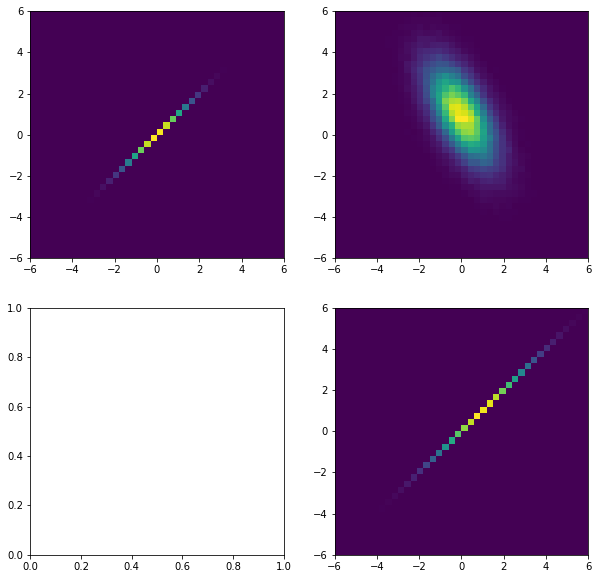

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

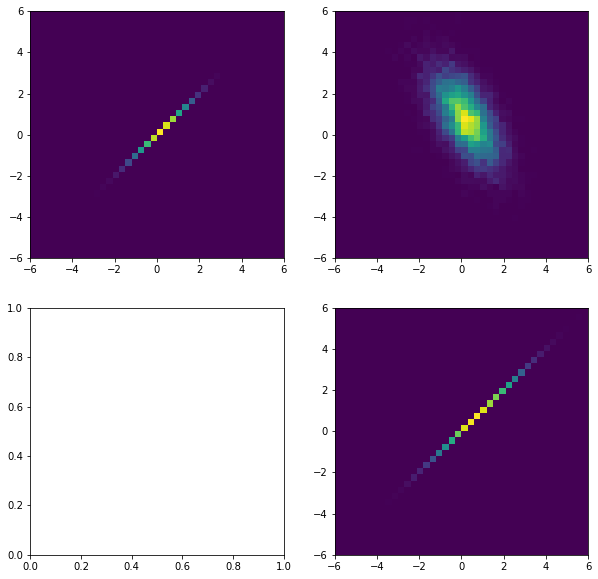

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

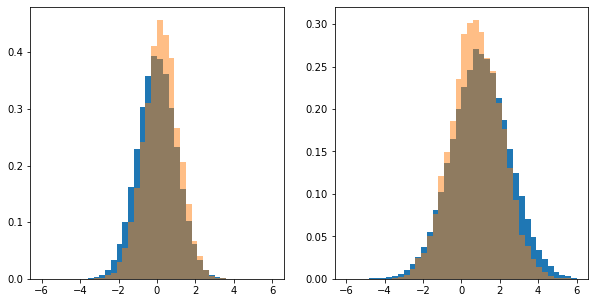

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.85990496 -0.17623176]
 [ 1.66475007 -2.06123886]
 [ 0.12678974  0.85282494]
 ...
 [-0.12419366 -0.5253946 ]
 [ 0.65051054 -0.9175329 ]
 [-0.17408452  0.18690193]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-1.05990496  0.02376824]
 [ 1.46475007 -1.86123886]
 [-0.07321026  1.05282494]
 ...
 [-0.32419366 -0.3253946 ]
 [ 0.45051054 -0.7175329 ]
 [-0.37408452  0.38690193]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 8.646721



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 14.212230



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.13395729 0.05943973 0.19019037 ... 0.22861173 0.20660995 0.26118629]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.11739745 0.0769296  0.21558362 ... 0.26889458 0.28555171 0.31136501]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

In [35]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [36]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [37]:
weights_true = np.ones( ngen_true )

In [38]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [39]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [40]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.217
  cov f0f0 :   0.8171
  sigma f0 :   0.9040
  cov f0f1 :  -0.6997
  mean f1 :    0.798
  cov f1f1 :   1.6901
  sigma f1 :   1.3000


In [41]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 2)
2


In [42]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [43]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 2
  mean f0 :    0.217
  cov f0f0 :   0.8171
  sigma f0 :   0.9040
  cov f0f1 :  -0.6997
  mean f1 :    0.798
  cov f1f1 :   1.6901
  sigma f1 :   1.3000


In [44]:
test_calc_true_model

{'mean': array([0.21738903, 0.79778764]),
 'cov': array([[ 0.81713644, -0.6996771 ],
        [-0.6996771 ,  1.69011161]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [45]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [46]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [47]:
test_calc_pdf_ratio

array([0.87637969, 1.29424534, 1.13351493, ..., 1.17620641, 1.38208111,
       1.1921185 ])

In [48]:
pdf_ratio

array([0.87637969, 1.29424534, 1.13351493, ..., 1.17620641, 1.38208111,
       1.1921185 ])

## Define OmniFold implementation with fit pdf

In [49]:
def fit_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
                                   model_pars_theta0_S['mean'],
                                   model_pars_theta_unknown_S['cov'],
                                   model_pars_theta0_S['cov'],
                                   theta0_S )

        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights

        weights[i, :1, :] = step1_output_weights

        if verbose>0 :
           print("  iter %d, step1_output_weights:" % (i+1))
           print(step1_output_weights)

            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        if verbose : print(' calculation of model pars with push weights')
        model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        if verbose : print(' calculation of model pars with pull weights')
        model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
                                   model_pars_theta0_G_push_weight['mean'],
                                   model_pars_theta0_G_pull_weight['cov'],
                                   model_pars_theta0_G_push_weight['cov'],
                                   theta0_G )        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [50]:
rd = fit_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 2)
  shape of theta0_G : (100000, 2)
  shape of theta_unknown_S : (10000, 2)

  iterations = 5

  ndim : 2
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)
 ndim = 2
  mean f0 :    0.213
  cov f0f0 :   1.0618
  sigma f0 :   1.0304
  cov f0f1 :  -0.6839
  mean f1 :    0.791
  cov f1f1 :   2.3379
  sigma f1 :   1.5290

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 ndim = 2
  mean f0 :   -0.002
  cov f0f0 :   1.2469
  sigma f0 :   1.1167
  cov f0f1 :  -0.9024
  mean f1 :    1.003
  cov f1f1 :   2.8897
  sigma f1 :   1.6999
  iter 1, step1_output_weights:
[0.73753969 1.32520111 1.08875971 ... 1.15596582 1.3067172  1.17026167]

   -- ITERATION 1  STEP 2

 calculation of model pars with push weights
 ndim = 2
  mean f0 :   -0.002
  cov f0f0 :   1.0024
  sigma f0 :   1.0012
  cov f0f1 :  -0.9016
  mean f1 :    1.001
  cov f1

In [51]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

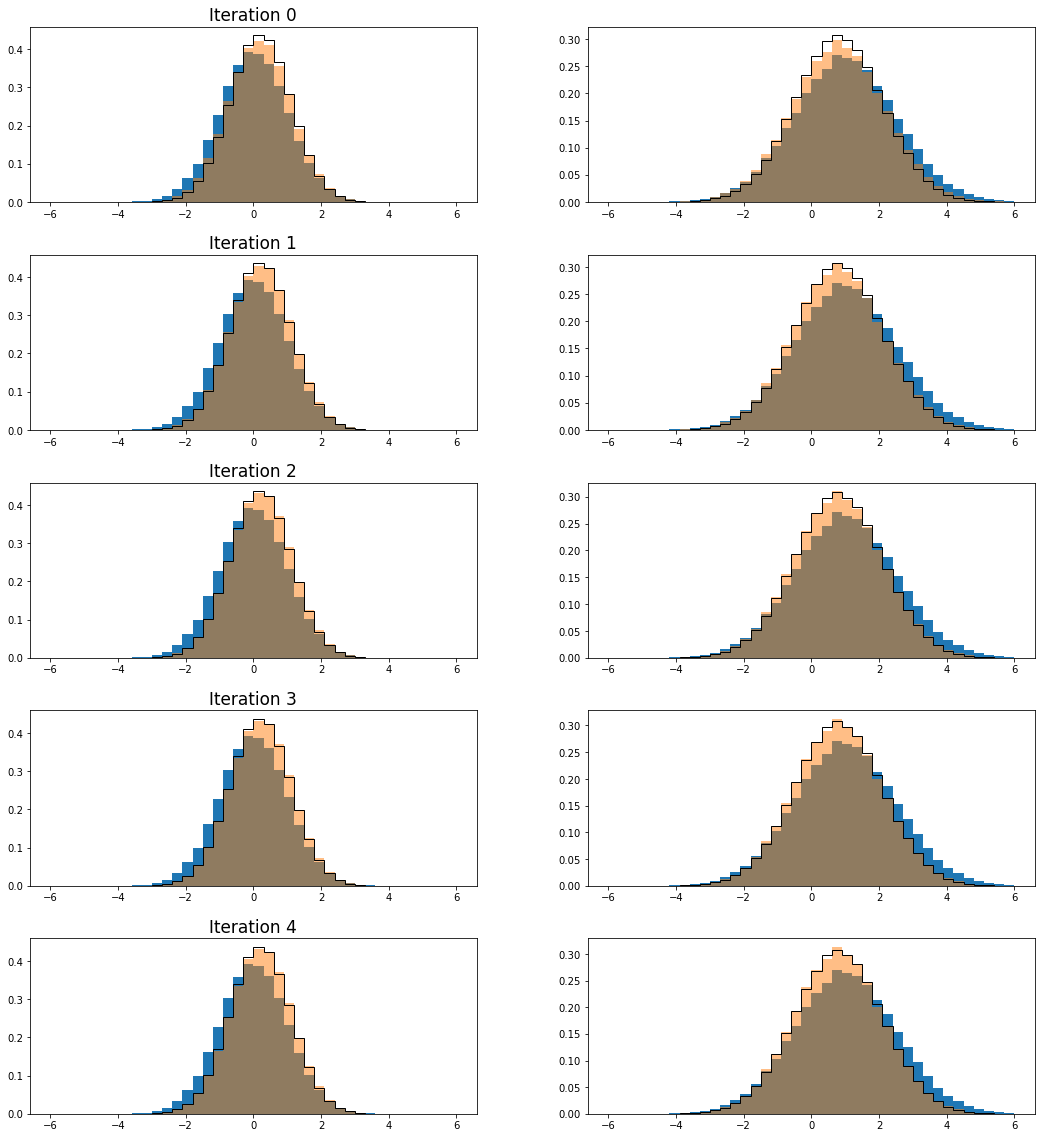

In [52]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [53]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

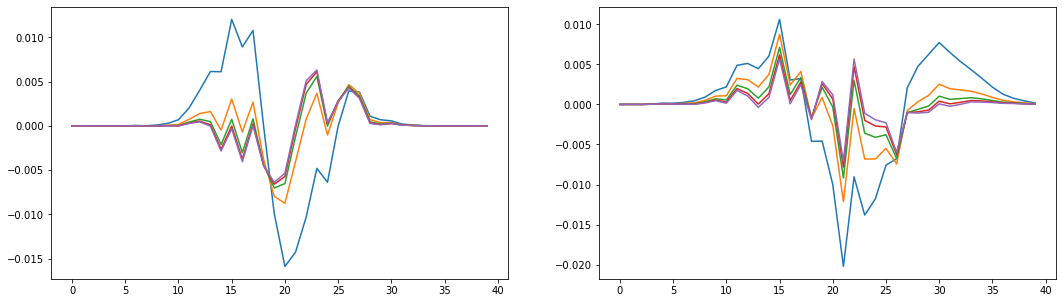

In [54]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

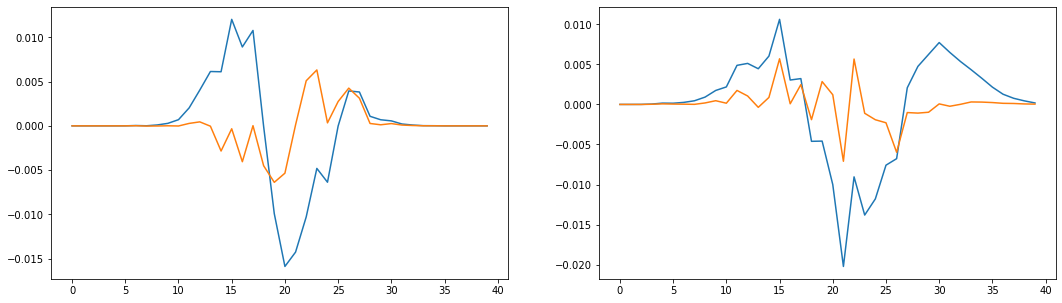

In [55]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

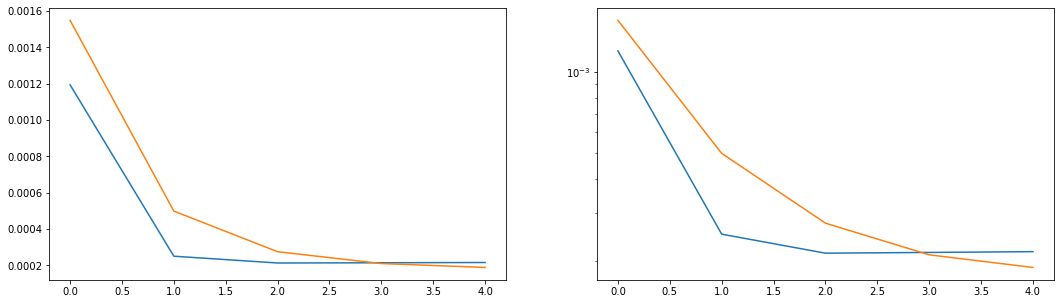

In [56]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

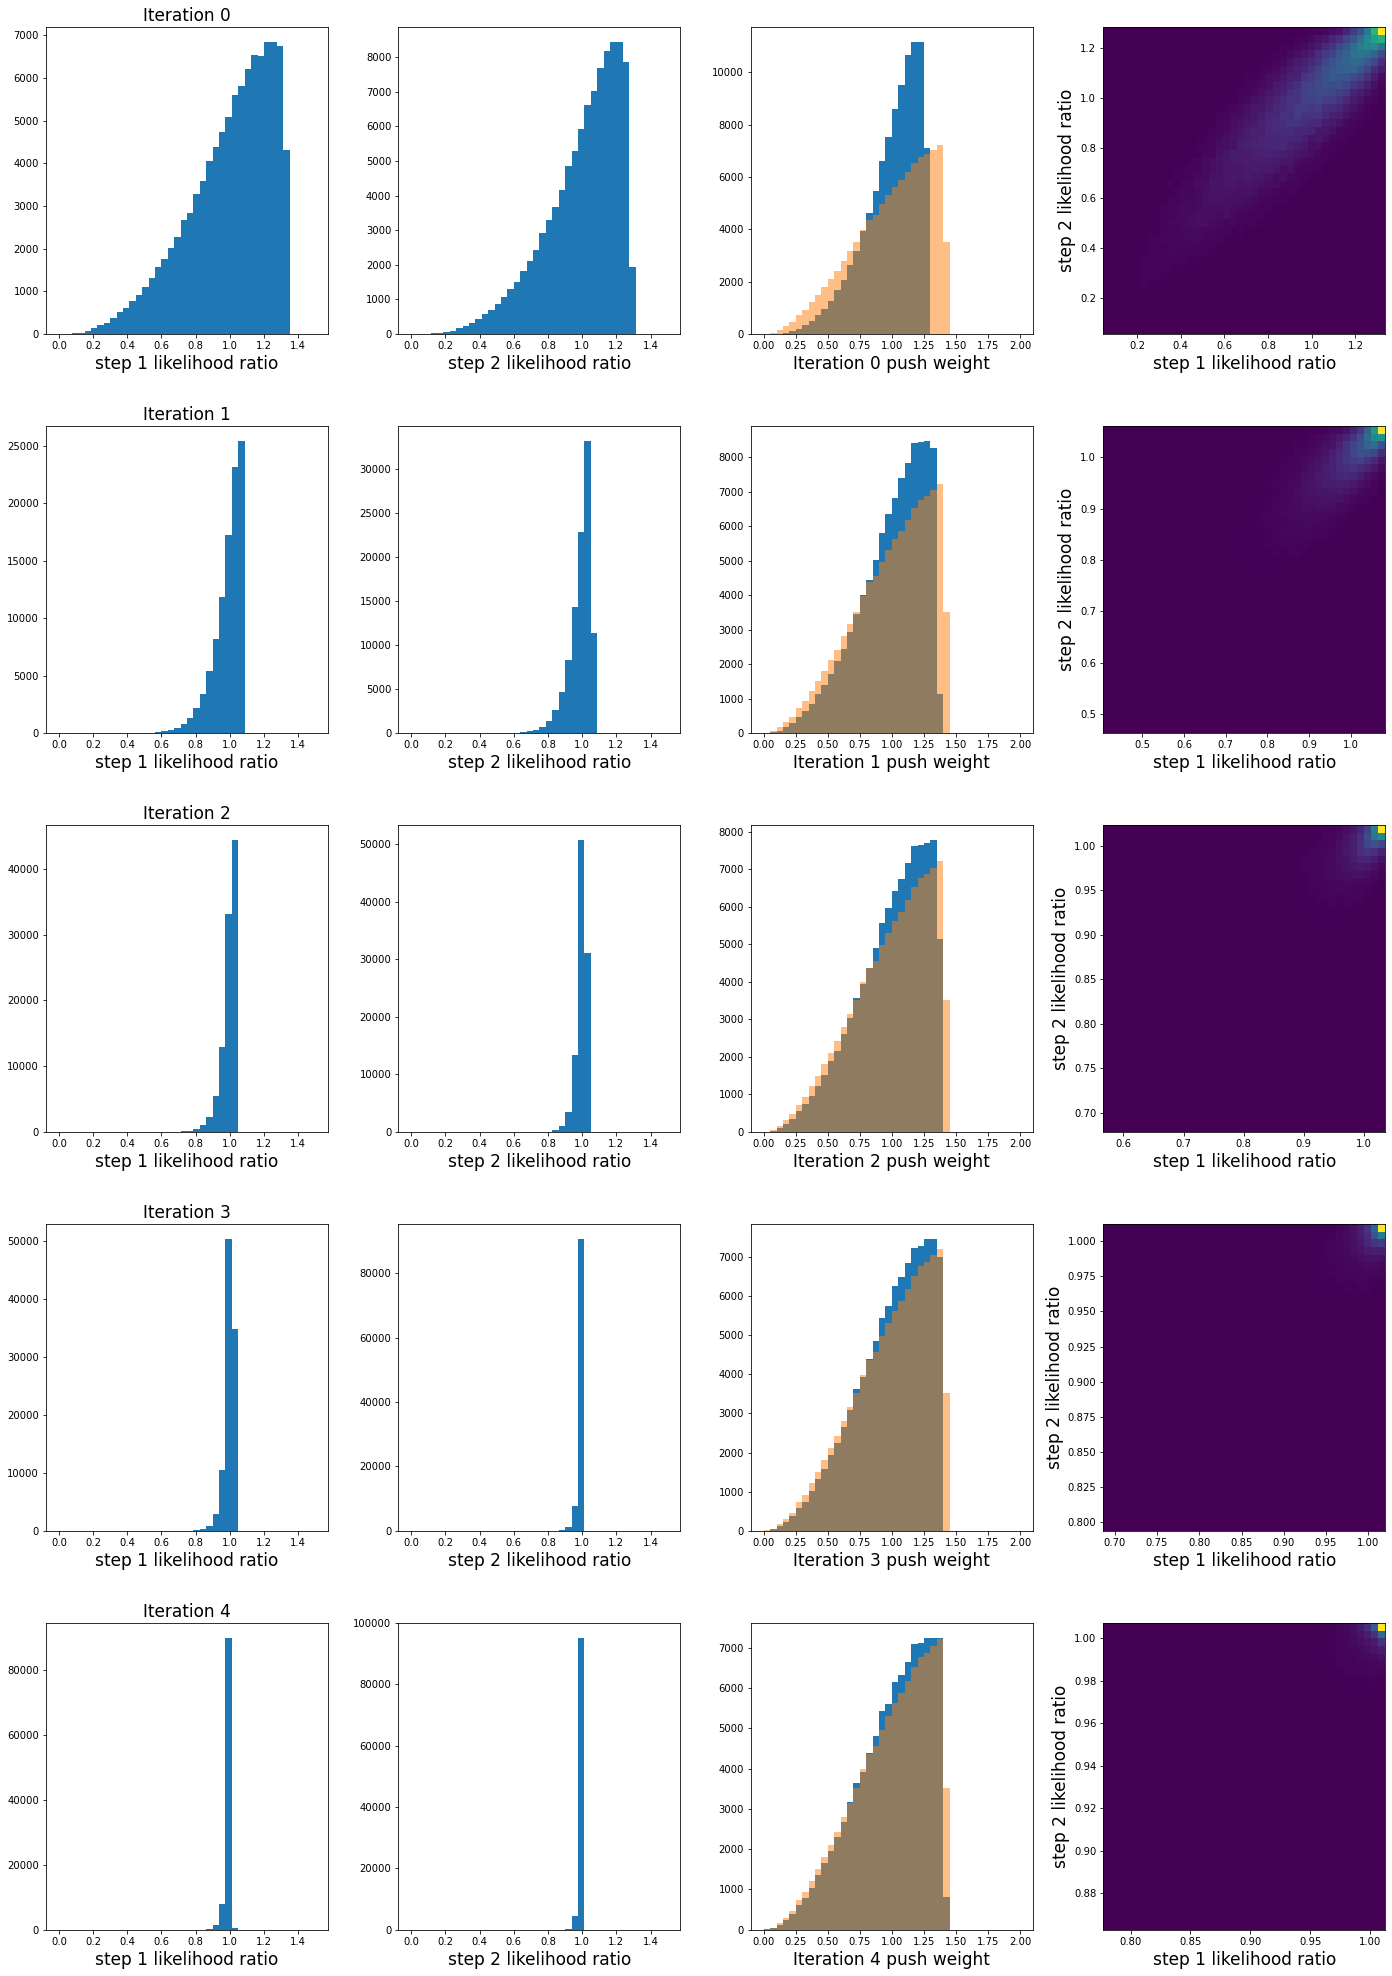

In [57]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

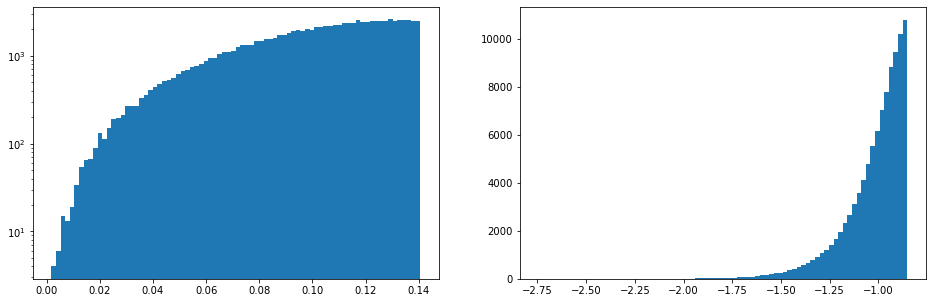

In [58]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

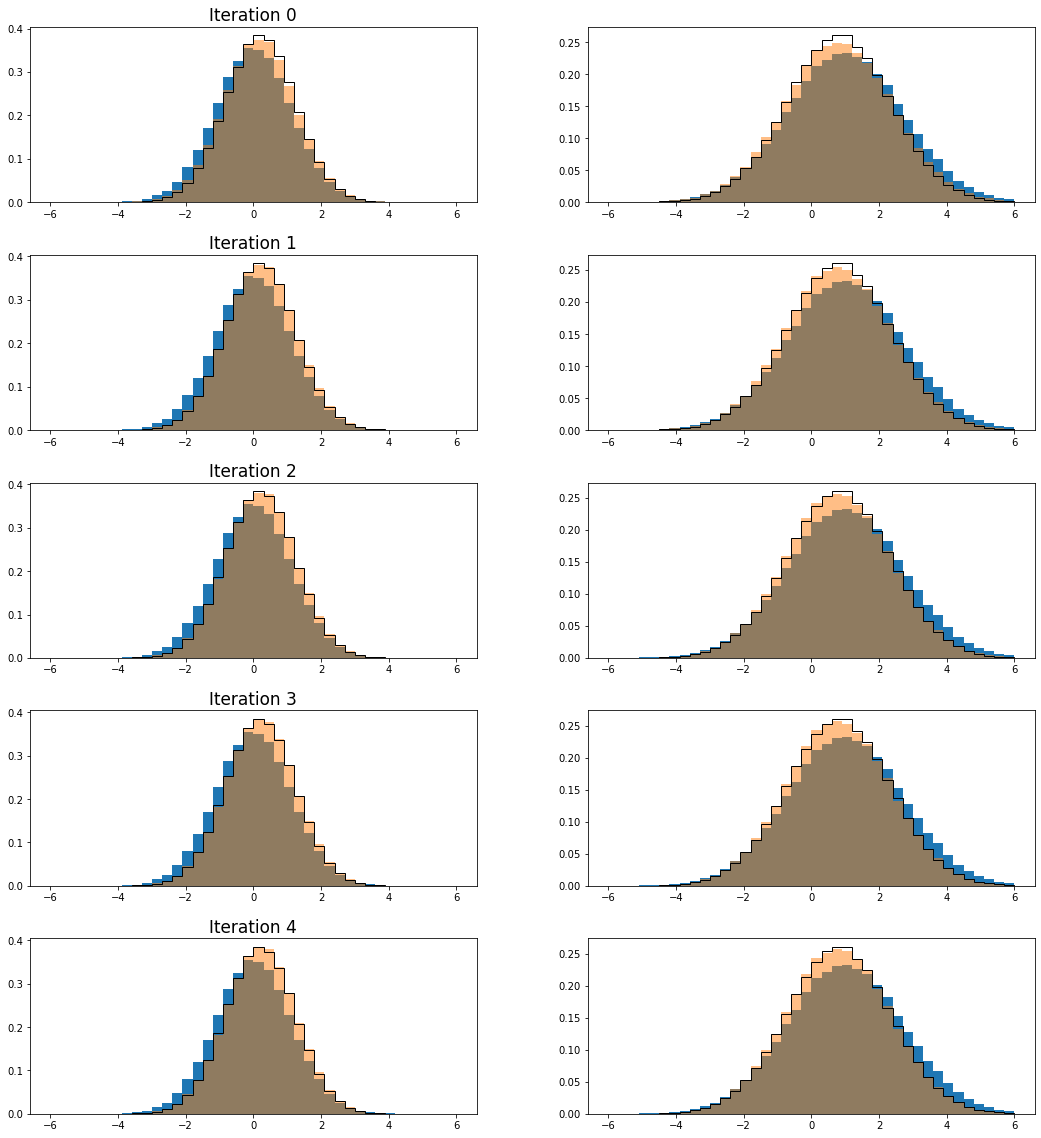

In [59]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [60]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

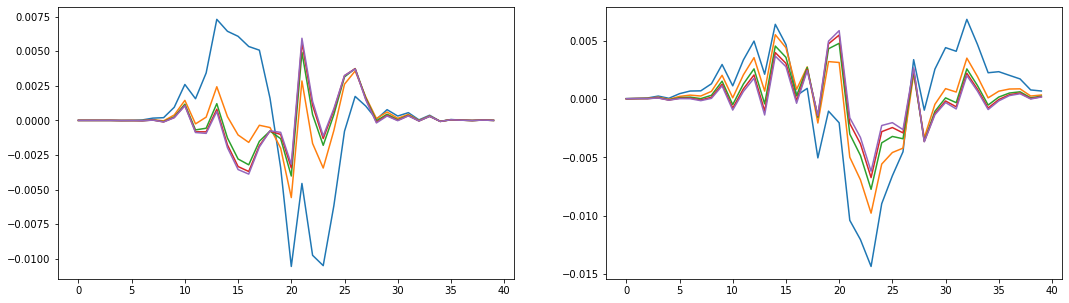

In [61]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

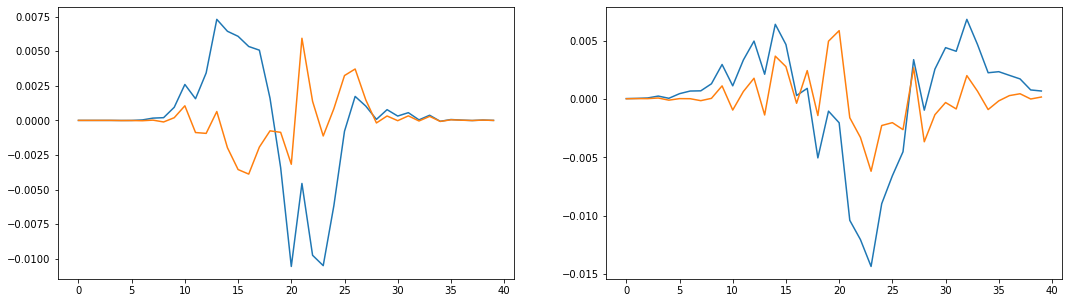

In [62]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

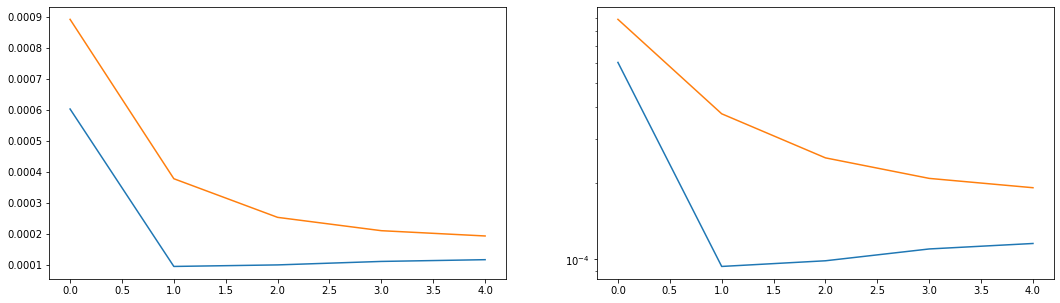

In [63]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [64]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.245      step 2 mean  1.000  rms 0.214
  iter  1 : step 1 mean  0.988  rms 0.083      step 2 mean  0.988  rms 0.064
  iter  2 : step 1 mean  0.995  rms 0.043      step 2 mean  0.995  rms 0.028
  iter  3 : step 1 mean  0.997  rms 0.027      step 2 mean  0.997  rms 0.017
  iter  4 : step 1 mean  0.998  rms 0.018      step 2 mean  0.998  rms 0.011


<function matplotlib.pyplot.show(close=None, block=None)>

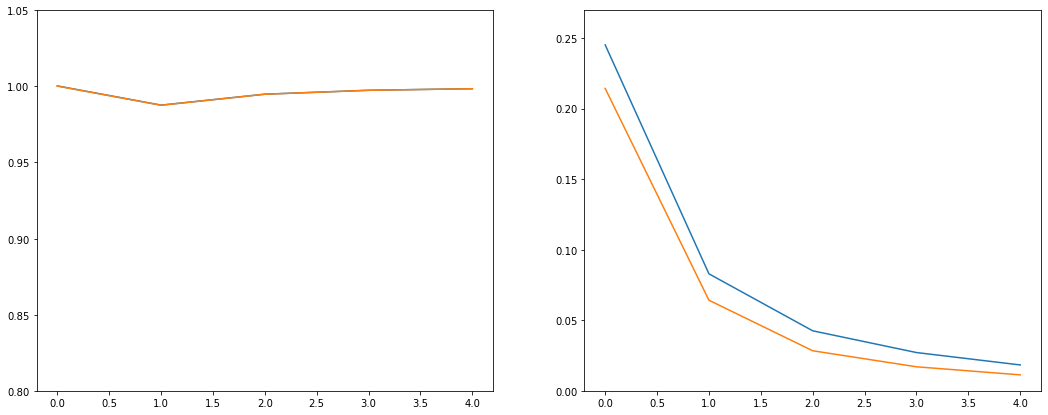

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

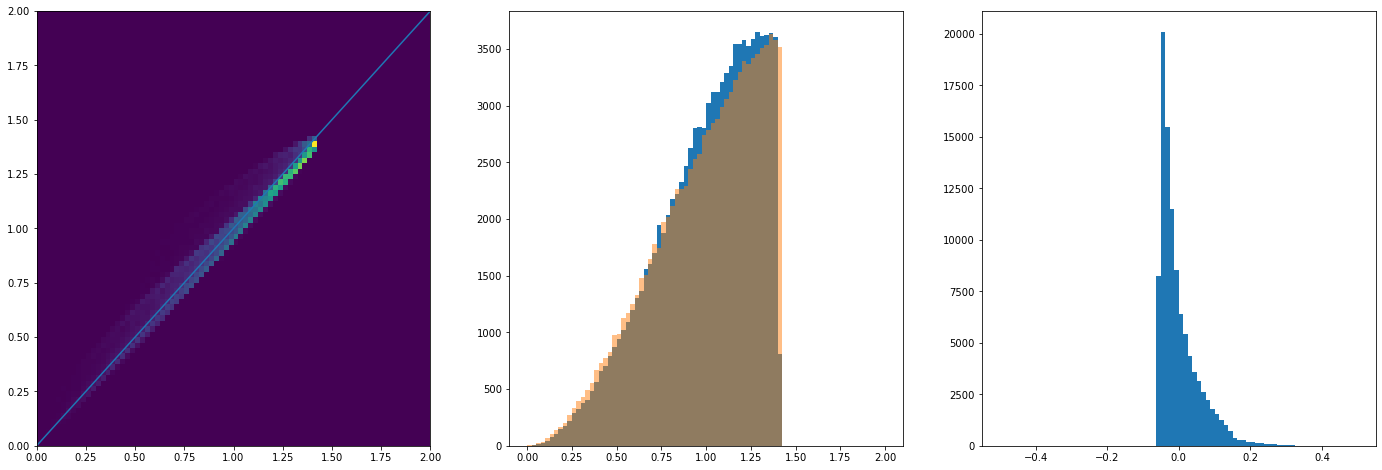

In [66]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [67]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.05488




In [68]:

verbose = False



import gc

In [70]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )
    
    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )

    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93618342 1.21954156 1.0543345  ... 1.10402259 1.22573492 1.07636376]
 weights_push at the beginning
[0.92009661 1.26348782 1.07719801 ... 1.13760858 1.29491965 1.11643191]
 weights_push at the beginning
[0.91410279 1.28354056 1.08883659 ... 1.15371375 1.32649551 1.14153419]
 weights_push at the beginning
[0.9102907  1.29806432 1.09481033 ... 1.16289336 1.34497425 1.15766064]


 bootstrap 0 final push weights scaled:
[0.09074317 0.13090258 0.10981042 ... 0.11687226 0.13571084 0.11684129]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9327854  1.18533629 1.06934116 ... 1.11389568 1.23328573 1.08315779]
 weights_push at the beginning
[0.91343843 1.21322601 1.09789296 ... 1.1492151  1.30318923 1.12335008]
 weights_push at the beginning
[0.9058384  1.22580117 1.11212246 ... 1.16520384 1.3337933  1.14736741]
 we

 weights_push at the beginning
[0.88079303 1.23808716 1.11040623 ... 1.13205233 1.30399526 1.11702939]
 weights_push at the beginning
[0.86793348 1.25339523 1.12780794 ... 1.14557387 1.335209   1.14077294]
 weights_push at the beginning
[0.86052323 1.26532998 1.13688094 ... 1.15306482 1.35303356 1.15576784]


 bootstrap 14 final push weights scaled:
[0.08557384 0.12747342 0.1141895  ... 0.1157791  0.1364543  0.11656406]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91477135 1.27139879 1.04345047 ... 1.09732649 1.23714037 1.064475  ]
 weights_push at the beginning
[0.89170314 1.32972326 1.06411117 ... 1.12810739 1.30882763 1.1009732 ]
 weights_push at the beginning
[0.88271063 1.35457507 1.07574715 ... 1.14339134 1.34158811 1.12516632]
 weights_push at the beginning
[0.87732432 1.37126467 1.08204268 ... 1.15233677 1.36084821 1.14108306]


 bootstrap 15 final push weights scaled:
[0.08735548 0.13834429 0.10856229 ... 0.


 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92986533 1.18694234 1.06942487 ... 1.10505112 1.22308393 1.07938195]
 weights_push at the beginning
[0.90901855 1.21775735 1.09871168 ... 1.13720784 1.28995557 1.11834894]
 weights_push at the beginning
[0.90045246 1.23178592 1.11334475 ... 1.15181326 1.31948355 1.14175822]
 weights_push at the beginning
[0.8953937  1.24295019 1.12079445 ... 1.15982794 1.33626837 1.15636691]


 bootstrap 29 final push weights scaled:
[0.0891977  0.12517799 0.11248493 ... 0.11648095 0.13470627 0.11659024]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92833687 1.18092519 1.07255669 ... 1.11025176 1.22870298 1.08234628]
 weights_push at the beginning
[0.9061712  1.20836532 1.10314563 ... 1.14406724 1.29745359 1.12217522]
 weights_push at the beginning
[0.89683325 1.22090261 1.11847308 ... 1.15929495 1.32770568 1.14591667]
 w

 weights_push at the beginning
[0.87171153 1.33160682 1.10820411 ... 1.13637639 1.33777969 1.14697909]


 bootstrap 43 final push weights scaled:
[0.08672593 0.13435264 0.11125406 ... 0.1141502  0.13501477 0.11577743]

 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92407314 1.23675506 1.05002102 ... 1.0999153  1.23242358 1.06414013]
 weights_push at the beginning
[0.9057489  1.27809391 1.07124055 ... 1.12950937 1.29813856 1.09672701]
 weights_push at the beginning
[0.90013826 1.29398303 1.08239829 ... 1.14321078 1.32582938 1.11720142]
 weights_push at the beginning
[0.89720336 1.30518139 1.08811326 ... 1.15079076 1.34113985 1.13009903]


 bootstrap 44 final push weights scaled:
[0.08952005 0.13136739 0.1091208  ... 0.11554917 0.13508382 0.11384925]

 Creating toy sample  45
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89919059 1.26384799 1.05600513 ... 1.08155169 1.22771966 1.

 weights_push at the beginning
[0.88297904 1.26865073 1.09768482 ... 1.14212586 1.32334842 1.11817945]
 weights_push at the beginning
[0.87133383 1.28638015 1.11347552 ... 1.15749573 1.35701554 1.14321131]
 weights_push at the beginning
[0.86453435 1.29975351 1.12178528 ... 1.16607118 1.37632293 1.15920978]


 bootstrap 58 final push weights scaled:
[0.08600091 0.13101739 0.11264024 ... 0.11714613 0.13888339 0.11698155]

 Creating toy sample  59
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92360261 1.21713062 1.06122392 ... 1.09826605 1.22453519 1.07240365]
 weights_push at the beginning
[0.90190271 1.2580072  1.0878296  ... 1.12816461 1.29153857 1.10962565]
 weights_push at the beginning
[0.89329972 1.27587562 1.10151971 ... 1.14213711 1.32135089 1.13278187]
 weights_push at the beginning
[0.88827632 1.28887306 1.10860829 ... 1.15002551 1.33849189 1.14752396]


 bootstrap 59 final push weights scaled:
[0.08848703 0.12987393 0.11125191 ... 0.


 Creating toy sample  73
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92639343 1.19028556 1.07681126 ... 1.10800473 1.23334157 1.08422869]
 weights_push at the beginning
[0.90456418 1.2206791  1.10857525 ... 1.14050495 1.30347965 1.12524387]
 weights_push at the beginning
[0.89584532 1.23462197 1.12431124 ... 1.15521547 1.33444678 1.14999038]
 weights_push at the beginning
[0.89077332 1.24604749 1.13227336 ... 1.163296   1.35207305 1.16550285]


 bootstrap 73 final push weights scaled:
[0.08873373 0.12552512 0.11365823 ... 0.1168339  0.13634522 0.11756685]

 Creating toy sample  74
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92654825 1.20246292 1.06215604 ... 1.09873382 1.21972872 1.071462  ]
 weights_push at the beginning
[0.90571699 1.23742857 1.08885958 ... 1.12839164 1.28407303 1.10710129]
 weights_push at the beginning
[0.89759859 1.25233037 1.10242672 ... 1.14192997 1.31205545 1.12880247]
 w

 weights_push at the beginning
[0.87136766 1.22992507 1.15446881 ... 1.15093618 1.34533261 1.16531251]


 bootstrap 87 final push weights scaled:
[0.08671069 0.12387772 0.11595811 ... 0.11553602 0.13564238 0.1175253 ]

 Creating toy sample  88
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93051712 1.17505528 1.07154227 ... 1.11705087 1.23315255 1.0849872 ]
 weights_push at the beginning
[0.90853818 1.19947759 1.10168654 ... 1.1536868  1.30371504 1.12580611]
 weights_push at the beginning
[0.89905058 1.21067692 1.11688985 ... 1.17018908 1.3347952  1.15000099]
 weights_push at the beginning
[0.8933479  1.22051924 1.12466706 ... 1.17904451 1.35228596 1.16493396]


 bootstrap 88 final push weights scaled:
[0.08895063 0.12286809 0.11289005 ... 0.11844228 0.1363429  0.11746001]

 Creating toy sample  89
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92623321 1.19168852 1.07664132 ... 1.09831456 1.22026254 1.

 weights_push at the beginning
[0.89478279 1.26167822 1.09013664 ... 1.12809566 1.29440147 1.11019123]
 weights_push at the beginning
[0.8846859  1.28016349 1.10456933 ... 1.14210467 1.32497335 1.13369664]
 weights_push at the beginning
[0.8787511  1.29357643 1.11212186 ... 1.15004137 1.34264195 1.14871905]


 bootstrap 102 final push weights scaled:
[0.08747764 0.1303741  0.11163212 ... 0.11550949 0.13541429 0.11586825]

 Creating toy sample 103
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92071364 1.20171564 1.06765257 ... 1.09812381 1.22326861 1.0719219 ]
 weights_push at the beginning
[0.89745097 1.23495722 1.09666386 ... 1.12667343 1.2880233  1.10720392]
 weights_push at the beginning
[0.88832187 1.24884269 1.11136051 ... 1.13951044 1.31585678 1.12860385]
 weights_push at the beginning
[0.88324625 1.25944591 1.11886578 ... 1.14656292 1.33142893 1.14195119]


 bootstrap 103 final push weights scaled:
[0.08799687 0.12677326 0.11229393 ... 


 Creating toy sample 117
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92952414 1.16932623 1.07537685 ... 1.1023649  1.21512154 1.08031879]
 weights_push at the beginning
[0.90718873 1.1955028  1.10730909 ... 1.13323993 1.27953585 1.11900157]
 weights_push at the beginning
[0.89753426 1.20779956 1.12308171 ... 1.14701323 1.30791355 1.14182265]
 weights_push at the beginning
[0.89186665 1.21801721 1.13108317 ... 1.15451018 1.32400292 1.15593184]


 bootstrap 117 final push weights scaled:
[0.08881358 0.12262221 0.1135427  ... 0.11591632 0.13343209 0.11650917]

 Creating toy sample 118
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90994231 1.20849316 1.07844114 ... 1.09993208 1.23510838 1.07800641]
 weights_push at the beginning
[0.88145227 1.24398969 1.11238656 ... 1.1284912  1.30505934 1.11653392]
 weights_push at the beginning
[0.86952448 1.2595535  1.12971245 ... 1.14137412 1.33585272 1.14021212]
 


 Creating toy sample 131
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92585102 1.19457855 1.07324904 ... 1.11695133 1.2412582  1.0892225 ]
 weights_push at the beginning
[0.90190175 1.22824498 1.10448299 ... 1.15430614 1.31716352 1.13398637]
 weights_push at the beginning
[0.89109276 1.24467482 1.12039756 ... 1.17166797 1.35203489 1.16136469]
 weights_push at the beginning
[0.88434769 1.25797373 1.12864662 ... 1.18128886 1.37234313 1.17874738]


 bootstrap 131 final push weights scaled:
[0.0879665  0.12685835 0.11332075 ... 0.11872958 0.13856164 0.1190277 ]

 Creating toy sample 132
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91691982 1.20528228 1.07247757 ... 1.10379122 1.23522802 1.076444  ]
 weights_push at the beginning
[0.8921168  1.23796589 1.10323779 ... 1.13395107 1.30407967 1.11365755]
 weights_push at the beginning
[0.88236684 1.25169696 1.11885874 ... 1.1475011  1.33377248 1.13630964]
 

 weights_push at the beginning
[0.89118424 1.25042255 1.12216265 ... 1.15936541 1.34542506 1.15272284]


 bootstrap 145 final push weights scaled:
[0.08881789 0.12588034 0.11261588 ... 0.11641186 0.13558374 0.11619066]

 Creating toy sample 146
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9216644  1.19314447 1.08092496 ... 1.11559442 1.24337948 1.09276665]
 weights_push at the beginning
[0.895394   1.22725484 1.1154486  ... 1.15199455 1.32075038 1.13930824]
 weights_push at the beginning
[0.88325508 1.2444549  1.13293873 ... 1.16885153 1.35665143 1.16783658]
 weights_push at the beginning
[0.87569538 1.25849125 1.14201174 ... 1.1782379  1.37774289 1.18605013]


 bootstrap 146 final push weights scaled:
[0.08704756 0.12697246 0.11470388 ... 0.11841508 0.13916309 0.11982046]

 Creating toy sample 147
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92706782 1.17647716 1.07824552 ... 1.0918867  1.20923789 

 weights_push at the beginning
[0.91201485 1.26093304 1.0846055  ... 1.14675333 1.31125869 1.12255117]
 weights_push at the beginning
[0.90463414 1.28003641 1.09743718 ... 1.16368969 1.34462896 1.14861179]
 weights_push at the beginning
[0.90002537 1.29432159 1.10404318 ... 1.17322852 1.36404193 1.16530205]


 bootstrap 160 final push weights scaled:
[0.08966731 0.13053164 0.1107678  ... 0.11792332 0.13767408 0.11764078]

 Creating toy sample 161
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92742197 1.22930655 1.05695114 ... 1.11871146 1.24966589 1.08353841]
 weights_push at the beginning
[0.90664893 1.27351489 1.08132868 ... 1.15777085 1.32812179 1.12727429]
 weights_push at the beginning
[0.89799937 1.29395402 1.0941706  ... 1.17654669 1.36435471 1.15491219]
 weights_push at the beginning
[0.8924638  1.30927848 1.10088378 ... 1.18713833 1.38558383 1.17274354]


 bootstrap 161 final push weights scaled:
[0.08884293 0.13211137 0.11046126 ... 



 bootstrap 174 final push weights scaled:
[0.08669646 0.12876005 0.11466413 ... 0.11608708 0.1373011  0.11848151]

 Creating toy sample 175
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92437831 1.22344365 1.05976474 ... 1.10413018 1.23206845 1.07651209]
 weights_push at the beginning
[0.90254643 1.26730835 1.08586642 ... 1.13698508 1.30326366 1.11654015]
 weights_push at the beginning
[0.89352328 1.28716839 1.09944944 ... 1.15260987 1.3357119  1.14169716]
 weights_push at the beginning
[0.88801713 1.30165384 1.10654468 ... 1.16148637 1.35464703 1.15786774]


 bootstrap 175 final push weights scaled:
[0.0884172  0.13126508 0.11104929 ... 0.11671266 0.13670542 0.11686514]

 Creating toy sample 176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94332044 1.18342362 1.06060945 ... 1.10439269 1.21381737 1.07781822]
 weights_push at the beginning
[0.92872333 1.21522518 1.08551115 ... 1.13746374 1.27802153 



 bootstrap 188 final push weights scaled:
[0.09019206 0.12977491 0.10917127 ... 0.11573952 0.13378319 0.11466585]

 Creating toy sample 189
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93385845 1.21907068 1.05417914 ... 1.09604085 1.21991213 1.0678554 ]
 weights_push at the beginning
[0.91887384 1.25845376 1.07641789 ... 1.1248802  1.28294761 1.10226506]
 weights_push at the beginning
[0.91454723 1.27450763 1.08757689 ... 1.13829054 1.31000892 1.12358207]
 weights_push at the beginning
[0.91220328 1.28600496 1.0931871  ... 1.14581448 1.32525746 1.13703826]


 bootstrap 189 final push weights scaled:
[0.09104909 0.12947304 0.1096211  ... 0.11505505 0.13350542 0.11458473]

 Creating toy sample 190
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92377682 1.21340083 1.06523841 ... 1.1013933  1.23082938 1.07398055]
 weights_push at the beginning
[0.9030282  1.24992675 1.09255925 ... 1.13142002 1.29823854 

 weights_push at the beginning
[0.89207361 1.2614613  1.11050573 ... 1.14118125 1.31942913 1.13620789]
 weights_push at the beginning
[0.88682219 1.27399307 1.11801921 ... 1.14882543 1.33643526 1.15098871]


 bootstrap 202 final push weights scaled:
[0.08832974 0.12836221 0.11221448 ... 0.11536776 0.13474711 0.11607394]

 Creating toy sample 203
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92222551 1.16847211 1.08231012 ... 1.09503503 1.21187156 1.07797372]
 weights_push at the beginning
[0.8971716  1.19374202 1.11718673 ... 1.1219993  1.27395004 1.11491481]
 weights_push at the beginning
[0.88652186 1.20528826 1.13427775 ... 1.13374552 1.30083254 1.13660539]
 weights_push at the beginning
[0.88053722 1.21494064 1.14289759 ... 1.14014752 1.31595646 1.14997719]


 bootstrap 203 final push weights scaled:
[0.08767451 0.12227305 0.11475452 ... 0.11441715 0.13256301 0.11586385]

 Creating toy sample 204
 weights_push at the beginning
[1. 1. 1. ..


 Creating toy sample 217
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93148003 1.19988033 1.06024457 ... 1.09669985 1.21500686 1.07011102]
 weights_push at the beginning
[0.91331018 1.23427406 1.08563731 ... 1.12565907 1.27726684 1.10492516]
 weights_push at the beginning
[0.90672137 1.24878051 1.09835752 ... 1.13885015 1.30409997 1.12603147]
 weights_push at the beginning
[0.9030045  1.25958765 1.1047962  ... 1.14613881 1.31917851 1.13920236]


 bootstrap 217 final push weights scaled:
[0.09004912 0.12678989 0.1108281  ... 0.11506891 0.13288164 0.11477682]

 Creating toy sample 218
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91460547 1.18078848 1.08658424 ... 1.09772435 1.22413662 1.0806252 ]
 weights_push at the beginning
[0.88676405 1.20838984 1.12340612 ... 1.12506537 1.29027393 1.11906161]
 weights_push at the beginning
[0.87492407 1.22090358 1.14166611 ... 1.13702122 1.31907855 1.14197143]
 

 weights_push at the beginning
[0.87723182 1.26344048 1.12737839 ... 1.14797709 1.3409161  1.14864136]


 bootstrap 231 final push weights scaled:
[0.08736501 0.12722396 0.11317485 ... 0.11524697 0.13514292 0.1157868 ]

 Creating toy sample 232
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9120538  1.23846134 1.06090621 ... 1.0929076  1.22846603 1.06872816]
 weights_push at the beginning
[0.8860747  1.2862604  1.08843943 ... 1.12051338 1.29675878 1.10523653]
 weights_push at the beginning
[0.87543442 1.30689395 1.10300399 ... 1.13362903 1.32743697 1.12855624]
 weights_push at the beginning
[0.8692878  1.32134765 1.11069235 ... 1.14120057 1.34525877 1.14363607]


 bootstrap 232 final push weights scaled:
[0.08652072 0.13321258 0.11149924 ... 0.11460991 0.13569207 0.11537102]

 Creating toy sample 233
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92471805 1.20418341 1.06453726 ... 1.10067427 1.22364742 

 weights_push at the beginning
[0.9271406  1.20522621 1.08920186 ... 1.14920027 1.29182948 1.12106208]
 weights_push at the beginning
[0.92148547 1.21750142 1.10185309 ... 1.16546407 1.32115559 1.14443913]
 weights_push at the beginning
[0.91801508 1.22771863 1.10818149 ... 1.17423941 1.33763291 1.1588576 ]


 bootstrap 246 final push weights scaled:
[0.09155084 0.12359649 0.11115787 ... 0.11795792 0.13481328 0.11681782]

 Creating toy sample 247
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94486696 1.16552135 1.07179792 ... 1.10895964 1.21695116 1.08602559]
 weights_push at the beginning
[0.9297395  1.19171859 1.10070003 ... 1.14331348 1.28295086 1.12771297]
 weights_push at the beginning
[0.92376441 1.2047019  1.11456048 ... 1.15891573 1.31240848 1.15232506]
 weights_push at the beginning
[0.9200098  1.21561884 1.12144112 ... 1.16744693 1.329279   1.16760039]


 bootstrap 247 final push weights scaled:
[0.09172824 0.122441   0.11251341 ... 


 Creating toy sample 261
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9295314  1.2008965  1.06093642 ... 1.10346336 1.2219088  1.07549473]
 weights_push at the beginning
[0.90892902 1.2371439  1.08734344 ... 1.1358722  1.28892353 1.11377457]
 weights_push at the beginning
[0.90036028 1.25342326 1.1008617  ... 1.15092579 1.31889876 1.1372008 ]
 weights_push at the beginning
[0.89519233 1.26568014 1.10785314 ... 1.15930693 1.33611341 1.15198226]


 bootstrap 261 final push weights scaled:
[0.08916522 0.12751158 0.1111711  ... 0.11645524 0.134725   0.11617018]

 Creating toy sample 262
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93700472 1.16978148 1.0790166  ... 1.11647217 1.23026397 1.09487921]
 weights_push at the beginning
[0.91657153 1.19868375 1.1117527  ... 1.15414997 1.30373696 1.14189887]
 weights_push at the beginning
[0.90707278 1.21415073 1.1278217  ... 1.17155527 1.33788723 1.17014137]
 

 weights_push at the beginning
[0.86666214 1.28413697 1.13136903 ... 1.16211006 1.36484439 1.16750788]


 bootstrap 275 final push weights scaled:
[0.08615649 0.12951631 0.11362934 ... 0.11675507 0.13778494 0.11787302]

 Creating toy sample 276
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93106629 1.20283613 1.06063704 ... 1.10168223 1.22314872 1.07201084]
 weights_push at the beginning
[0.91313364 1.23630926 1.08584036 ... 1.13220194 1.28765017 1.10742257]
 weights_push at the beginning
[0.90689553 1.25019088 1.09848729 ... 1.14606261 1.3152554  1.12888389]
 weights_push at the beginning
[0.90341558 1.26073833 1.10486684 ... 1.15365139 1.33065112 1.14224027]


 bootstrap 276 final push weights scaled:
[0.09010421 0.12689649 0.11083013 ... 0.1158345  0.13404451 0.11509018]

 Creating toy sample 277
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92195858 1.19002304 1.07613384 ... 1.10086951 1.22283195 

 weights_push at the beginning
[0.87178601 1.26861163 1.14000828 ... 1.13803635 1.33679847 1.15626175]


 bootstrap 289 final push weights scaled:
[0.08676736 0.12784782 0.11448478 ... 0.11424563 0.13480534 0.11664003]

 Creating toy sample 290
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93941717 1.21846491 1.05488854 ... 1.12165445 1.2463481  1.08543531]
 weights_push at the beginning
[0.92439769 1.25921952 1.07703007 ... 1.16213717 1.3232727  1.12940867]
 weights_push at the beginning
[0.91893673 1.27822325 1.08829665 ... 1.18151186 1.35849307 1.15683282]
 weights_push at the beginning
[0.91527735 1.29274062 1.09401683 ... 1.19236109 1.37899577 1.17438425]


 bootstrap 290 final push weights scaled:
[0.09123901 0.13040397 0.10971282 ... 0.11991225 0.13924048 0.11860628]

 Creating toy sample 291
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88803205 1.23339038 1.08635348 ... 1.09544698 1.24775115 


 Creating toy sample 304
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91408814 1.23623341 1.06586833 ... 1.10642376 1.24626841 1.07864977]
 weights_push at the beginning
[0.88854546 1.28170064 1.094555   ... 1.13900689 1.32162997 1.11956727]
 weights_push at the beginning
[0.87806481 1.30196703 1.10960763 ... 1.15443067 1.35580194 1.14555158]
 weights_push at the beginning
[0.87184984 1.31687253 1.1174985  ... 1.163189   1.37567746 1.16233829]


 bootstrap 304 final push weights scaled:
[0.08675965 0.13283096 0.11218851 ... 0.11687697 0.13887032 0.11735684]

 Creating toy sample 305
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92679255 1.21589129 1.05975398 ... 1.10509946 1.2285646  1.07808221]
 weights_push at the beginning
[0.90495311 1.25876393 1.08604974 ... 1.13887512 1.29965468 1.11903615]
 weights_push at the beginning
[0.89546716 1.2786781  1.09972035 ... 1.15498506 1.33244651 1.14466902]
 

 weights_push at the beginning
[0.895543   1.27763445 1.09530297 ... 1.15058628 1.32770112 1.1342935 ]


 bootstrap 318 final push weights scaled:
[0.0892746  0.12860218 0.10987481 ... 0.11553135 0.13375049 0.11427666]

 Creating toy sample 319
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94138557 1.165629   1.07280535 ... 1.11450143 1.22911174 1.08300375]
 weights_push at the beginning
[0.92677927 1.18402637 1.1009849  ... 1.14880637 1.29470848 1.12088518]
 weights_push at the beginning
[0.92234894 1.19158182 1.11439247 ... 1.16377393 1.32195885 1.14274106]
 weights_push at the beginning
[0.91997842 1.19907041 1.12088076 ... 1.17160013 1.3366952  1.15590108]


 bootstrap 319 final push weights scaled:
[0.09183081 0.12056303 0.11242416 ... 0.11762599 0.1345873  0.1164232 ]

 Creating toy sample 320
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93418908 1.18628969 1.07103597 ... 1.10319965 1.22074522 

 weights_push at the beginning
[0.92769277 1.18650241 1.09728752 ... 1.1416259  1.27980584 1.11928818]
 weights_push at the beginning
[0.92208799 1.19682172 1.11069062 ... 1.15638115 1.30707822 1.14150755]
 weights_push at the beginning
[0.91878612 1.20584304 1.11730009 ... 1.16425973 1.32223881 1.15504635]


 bootstrap 333 final push weights scaled:
[0.09164742 0.12132654 0.11208051 ... 0.11690405 0.13318389 0.11637226]

 Creating toy sample 334
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91885724 1.22025774 1.06672744 ... 1.1004662  1.23313109 1.07487852]
 weights_push at the beginning
[0.89555899 1.26021411 1.09531316 ... 1.1303363  1.30238469 1.1128376 ]
 weights_push at the beginning
[0.88647826 1.27748672 1.10996059 ... 1.14417121 1.3329567  1.136466  ]
 weights_push at the beginning
[0.88129361 1.29029366 1.11751261 ... 1.15194758 1.35043792 1.15150403]


 bootstrap 334 final push weights scaled:
[0.08778196 0.1300159  0.11216555 ... 


 Creating toy sample 348
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92518485 1.21641677 1.05140472 ... 1.10055711 1.22191537 1.06674309]
 weights_push at the beginning
[0.90407303 1.25482319 1.07452897 ... 1.13157706 1.28686522 1.1010086 ]
 weights_push at the beginning
[0.89571713 1.27057003 1.08681202 ... 1.14598332 1.31518714 1.12224365]
 weights_push at the beginning
[0.89086035 1.28192547 1.09325064 ... 1.15396483 1.33117332 1.13561539]


 bootstrap 348 final push weights scaled:
[0.08876127 0.12905504 0.10968186 ... 0.11589216 0.13413913 0.11443529]

 Creating toy sample 349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91833626 1.20927225 1.07325329 ... 1.09416092 1.22226996 1.07754684]
 weights_push at the beginning
[0.89300271 1.25023193 1.1051501  ... 1.12215871 1.29008749 1.11739954]
 weights_push at the beginning
[0.88209851 1.26922863 1.12133635 ... 1.13520105 1.32098006 1.14217875]
 

 weights_push at the beginning
[0.87113434 1.29968221 1.12345295 ... 1.15116399 1.35465129 1.15780715]


 bootstrap 362 final push weights scaled:
[0.086672   0.13106451 0.11280381 ... 0.11563023 0.1366982  0.11685563]

 Creating toy sample 363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92994545 1.19922199 1.07512368 ... 1.10788148 1.23648734 1.08489636]
 weights_push at the beginning
[0.91108686 1.23184089 1.10531006 ... 1.14039567 1.30729558 1.12661679]
 weights_push at the beginning
[0.90434508 1.24648688 1.12008163 ... 1.15530051 1.33855644 1.15207773]
 weights_push at the beginning
[0.90045659 1.25829832 1.12747055 ... 1.1635872  1.35643777 1.16817405]


 bootstrap 363 final push weights scaled:
[0.08977028 0.12678024 0.11314388 ... 0.11688029 0.13680594 0.11787873]

 Creating toy sample 364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92157356 1.20631105 1.07220456 ... 1.10548995 1.23518935 

 weights_push at the beginning
[0.90585406 1.248416   1.09093278 ... 1.13077366 1.29209175 1.11297854]
 weights_push at the beginning
[0.89777405 1.26542742 1.10472567 ... 1.14495446 1.32192966 1.13643456]
 weights_push at the beginning
[0.89304354 1.2780669  1.11180485 ... 1.15291398 1.33905158 1.15130655]


 bootstrap 377 final push weights scaled:
[0.08898075 0.12877636 0.11156862 ... 0.11579452 0.13501553 0.11611149]

 Creating toy sample 378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92783007 1.16916726 1.07960318 ... 1.10603215 1.22304831 1.0828633 ]
 weights_push at the beginning
[0.90526794 1.19302122 1.11275726 ... 1.13750473 1.28921743 1.12206664]
 weights_push at the beginning
[0.89587104 1.20403873 1.1290349  ... 1.15138095 1.31796615 1.1450884 ]
 weights_push at the beginning
[0.890471   1.21365482 1.13722723 ... 1.15884771 1.33408697 1.15924751]


 bootstrap 378 final push weights scaled:
[0.08869379 0.12215792 0.11416335 ... 

 weights_push at the beginning
[0.8946767  1.26749198 1.11670923 ... 1.15413283 1.33600473 1.15734473]


 bootstrap 391 final push weights scaled:
[0.08911151 0.12774936 0.11207487 ... 0.11592931 0.13474787 0.11675466]

 Creating toy sample 392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92030611 1.22742948 1.06701309 ... 1.1023292  1.23623883 1.07982167]
 weights_push at the beginning
[0.89694764 1.27298357 1.095878   ... 1.13394405 1.30917549 1.12160837]
 weights_push at the beginning
[0.88727088 1.2939589  1.1107155  ... 1.14899019 1.34267092 1.14803262]
 weights_push at the beginning
[0.88140189 1.30934331 1.11843441 ... 1.15762949 1.36239345 1.16515513]


 bootstrap 392 final push weights scaled:
[0.08773039 0.13210787 0.1122722  ... 0.11631933 0.13754329 0.11766611]

 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92177308 1.22414942 1.05765269 ... 1.10382005 1.23182106 


 Creating toy sample 406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93130723 1.15458753 1.08144955 ... 1.1037136  1.21094655 1.08663908]
 weights_push at the beginning
[0.9074433  1.17957412 1.11627866 ... 1.13589815 1.2766651  1.12877533]
 weights_push at the beginning
[0.89608058 1.19272189 1.13343065 ... 1.15039966 1.30669742 1.15359519]
 weights_push at the beginning
[0.88911474 1.20388301 1.14220477 ... 1.15837682 1.32414387 1.16905723]


 bootstrap 406 final push weights scaled:
[0.08844619 0.12128569 0.11470255 ... 0.11633775 0.13354987 0.11791961]

 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91947796 1.19247528 1.07265688 ... 1.10178325 1.22708909 1.07473673]
 weights_push at the beginning
[0.89515863 1.22126836 1.10350263 ... 1.13111203 1.29273683 1.11047353]
 weights_push at the beginning
[0.8855139  1.23317111 1.11901997 ... 1.14407103 1.3206699  1.1318517 ]
 

 weights_push at the beginning
[0.94335548 1.20550191 1.07523513 ... 1.12886429 1.26214825 1.10207032]
 weights_push at the beginning
[0.94206702 1.21597925 1.0850753  ... 1.14210624 1.28566628 1.12124834]
 weights_push at the beginning
[0.94142861 1.22425779 1.08979065 ... 1.14919655 1.29847321 1.13289392]


 bootstrap 420 final push weights scaled:
[0.0940776  0.12308423 0.10922395 ... 0.11534955 0.13065051 0.1140305 ]

 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92967842 1.1937477  1.06844061 ... 1.09683473 1.2174531  1.07413232]
 weights_push at the beginning
[0.91052548 1.22594974 1.09680489 ... 1.12525267 1.28057635 1.11039896]
 weights_push at the beginning
[0.90352192 1.23977742 1.11077306 ... 1.13807496 1.30779887 1.13226   ]
 weights_push at the beginning
[0.89961925 1.25043808 1.11778526 ... 1.14516646 1.32312993 1.14590084]


 bootstrap 421 final push weights scaled:
[0.08970052 0.12587882 0.11215575 ... 


 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92591285 1.20014831 1.06777347 ... 1.10875605 1.23431087 1.07871151]
 weights_push at the beginning
[0.90461275 1.23219726 1.09616145 ... 1.14173292 1.30377498 1.11723232]
 weights_push at the beginning
[0.89636249 1.24606322 1.11051529 ... 1.15671419 1.33403239 1.14058418]
 weights_push at the beginning
[0.89162138 1.25707905 1.11782765 ... 1.16489054 1.35104419 1.15516595]


 bootstrap 435 final push weights scaled:
[0.08884287 0.12658535 0.1121792  ... 0.11699379 0.13619152 0.11646643]

 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91160129 1.24515345 1.05607795 ... 1.08327226 1.22056139 1.05821403]
 weights_push at the beginning
[0.8881158  1.29143298 1.08095871 ... 1.10611656 1.282142   1.08876793]
 weights_push at the beginning
[0.87991638 1.30935421 1.09400534 ... 1.11678625 1.3082391  1.10836171]
 

 weights_push at the beginning
[0.92321841 1.26749153 1.10114214 ... 1.15290359 1.3222843  1.15656965]


 bootstrap 449 final push weights scaled:
[0.09209258 0.12775531 0.11043675 ... 0.115828   0.13334939 0.11668572]

 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93573907 1.19887641 1.06685717 ... 1.10810195 1.23057222 1.0817854 ]
 weights_push at the beginning
[0.91922734 1.23277099 1.09382784 ... 1.14159809 1.29975089 1.12233975]
 weights_push at the beginning
[0.91343158 1.24806275 1.10708445 ... 1.15706841 1.33037047 1.1470347 ]
 weights_push at the beginning
[0.90997973 1.26005844 1.11372169 ... 1.16565171 1.34787391 1.16259579]


 bootstrap 450 final push weights scaled:
[0.09074633 0.12695315 0.11172941 ... 0.11710177 0.13592122 0.11728243]

 Creating toy sample 451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91754996 1.20416952 1.07484708 ... 1.09155047 1.22303844 



 bootstrap 463 final push weights scaled:
[0.08836896 0.12358321 0.11400106 ... 0.11541244 0.13369187 0.11656756]

 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92932582 1.1784226  1.07931576 ... 1.10598151 1.22277301 1.08902211]
 weights_push at the beginning
[0.90586256 1.21140755 1.1131038  ... 1.13932989 1.29336099 1.13372496]
 weights_push at the beginning
[0.89488842 1.22844224 1.12988993 ... 1.15474579 1.32622826 1.16082093]
 weights_push at the beginning
[0.88800302 1.24209683 1.13852799 ... 1.16340121 1.34564268 1.1780536 ]


 bootstrap 464 final push weights scaled:
[0.0883243  0.125285   0.11433065 ... 0.11689053 0.13584596 0.11895328]

 Creating toy sample 465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91300728 1.18664226 1.07903681 ... 1.09891667 1.2221646  1.07860232]
 weights_push at the beginning
[0.88322949 1.21802924 1.11408324 ... 1.12800748 1.28952766 



 bootstrap 477 final push weights scaled:
[0.08766968 0.12679506 0.11416655 ... 0.11583428 0.13551041 0.11790774]

 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91476602 1.21914107 1.06578488 ... 1.09884912 1.23106614 1.07157914]
 weights_push at the beginning
[0.88943729 1.25782069 1.09458971 ... 1.12780582 1.29894292 1.10765069]
 weights_push at the beginning
[0.87930277 1.27407189 1.1095251  ... 1.14108187 1.3285707  1.13002802]
 weights_push at the beginning
[0.87359675 1.2860759  1.117274   ... 1.14848489 1.34534355 1.14418613]


 bootstrap 478 final push weights scaled:
[0.08698843 0.12953159 0.11215327 ... 0.1153154  0.13561232 0.11534865]

 Creating toy sample 479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91661167 1.16167631 1.08837504 ... 1.11631093 1.23781784 1.08931089]
 weights_push at the beginning
[0.88694366 1.18029579 1.12625227 ... 1.15104044 1.30990414 

 weights_push at the beginning
[0.9008496  1.22631154 1.1033202  ... 1.12805388 1.28634296 1.11569577]
 weights_push at the beginning
[0.89122088 1.24149256 1.1188151  ... 1.14140796 1.31553582 1.13892029]
 weights_push at the beginning
[0.88563132 1.25323405 1.12674183 ... 1.14883804 1.33223937 1.15352172]


 bootstrap 491 final push weights scaled:
[0.08819292 0.12623968 0.11310758 ... 0.11535334 0.13430459 0.11631087]

 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91927676 1.24617678 1.05779646 ... 1.11357008 1.2539736  1.07949528]
 weights_push at the beginning
[0.89665154 1.2941862  1.08266941 ... 1.14968564 1.33235035 1.12137255]
 weights_push at the beginning
[0.88776274 1.31552675 1.09590595 ... 1.16705477 1.3680865  1.14820536]
 weights_push at the beginning
[0.88235272 1.33112006 1.1028452  ... 1.17691068 1.38890406 1.16560124]


 bootstrap 492 final push weights scaled:
[0.08784965 0.13430603 0.11066964 ... 

In [71]:
print('\n\n Done \n\n')



 Done 


